# Generic analysis with dynamic indicators and stability time

### Execute this cell for better plots

In [1]:
%matplotlib widget

### Libraries

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tqdm.autonotebook import tqdm
from numba import njit, prange

DPI = 600

<ipython-input-1-aa0e6262dfc3>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Directories (local computer)

In [2]:
outdir = "../data"
inputdir = "../data"
imgdir = "../img"

## Directories (SWAN instance + CERNBox file system)

In [3]:
outdir = "../data"
inputdir = "../data"
imgdir = "../img"

## Data Filename list

In [4]:
epsilon = 0.0
mu = 0.0

eps_mu_label = "eps_{:1}_mu_{:1}_".format(epsilon, mu).replace(".","_")
print(eps_mu_label)

eps_0_0_mu_0_0_


In [5]:
init_file = "henon_4d_init_" + eps_mu_label + "id_basic_view.hdf5"

displacement_file = "henon_4d_displacement_" + eps_mu_label + "id_basic_view_subid_1e-14.hdf5"
inversion_file = "henon_4d_inverse_tracking_" + eps_mu_label + "id_basic_view_subid_no_kick.hdf5"
inversion_gauss_file = "henon_4d_inverse_tracking_" + eps_mu_label + "id_basic_view_subid_gauss_kick.hdf5"
inversion_uniform_file = "henon_4d_inverse_tracking_" + eps_mu_label + "id_basic_view_subid_unif_kick.hdf5"
inversion_gauss_forward_file = "henon_4d_inverse_tracking_" + eps_mu_label + "id_basic_view_subid_gauss_kick_forward.hdf5"
inversion_uniform_forward_file = "henon_4d_inverse_tracking_" + eps_mu_label + "id_basic_view_subid_unif_kick_forward.hdf5"
tracking_file = "henon_4d_long_track_" + eps_mu_label + "id_basic_view.hdf5"
orto_displacement_file = "henon_4d_orto_displacement_" + eps_mu_label + "id_basic_view_subid_1e-14.hdf5"
full_track_file = "henon_4d_verbose_track_" + eps_mu_label + "id_basic_view.hdf5"
tracking_wkick_file = "henon_4d_long_track_wkick_" + eps_mu_label + "id_basic_view_subid_1e-8.hdf5"
tracking_wkick_file2 = "henon_4d_long_track_wkick_" + eps_mu_label + "id_basic_view_subid_1e-12.hdf5"
megno_file = "henon_4d_megno_" + eps_mu_label + "id_basic_view.hdf5"
sali_file = "henon_4d_sali_" + eps_mu_label + "id_basic_view.hdf5"
gali_file = "henon_4d_gali_" + eps_mu_label + "id_basic_view.hdf5"
fft_file = "henon_4d_fft_" + eps_mu_label + "id_basic_view.hdf5"

## Load Initial conditions

In [6]:
initial_conditions = h5py.File(os.path.join(inputdir, init_file), mode="r")

## Long tracking

In [7]:
long_tracking = h5py.File(os.path.join(inputdir, tracking_file), mode="r")

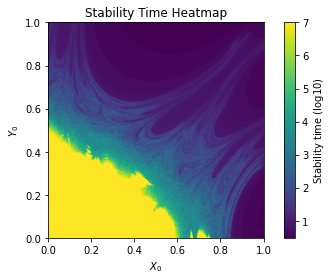

In [8]:
plt.figure()
plt.imshow(np.log10(long_tracking["stability_time"]), origin="lower", extent=[0,1,0,1])

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Stability time $(\\log10)$")
plt.title("Stability Time Heatmap")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time.png"), dpi=DPI)

## Long tracking (with kicks)

In [9]:
long_tracking_wkick = h5py.File(os.path.join(inputdir, tracking_wkick_file), mode="r")

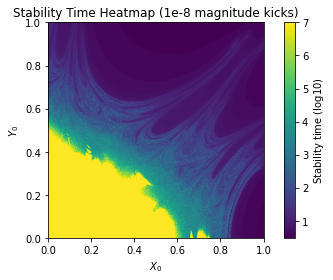

In [10]:
plt.figure()
plt.imshow(np.log10(long_tracking_wkick["stability_time"]), origin="lower", extent=[0,1,0,1])

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Stability time $(\\log10)$")
plt.title("Stability Time Heatmap (1e-8 magnitude kicks)")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time_wkicks_1e-8.png"), dpi=DPI)

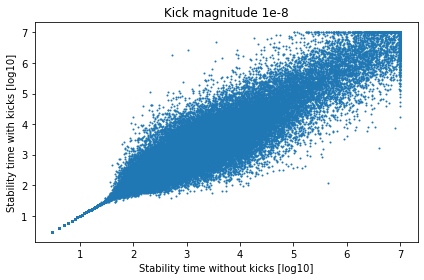

In [11]:
plt.figure()

plt.scatter(
    np.log10(long_tracking["stability_time"]), 
    np.log10(long_tracking_wkick["stability_time"]),
    s=1)

plt.xlabel("Stability time without kicks [log10]")
plt.ylabel("Stability time with kicks [log10]")
plt.title("Kick magnitude 1e-8")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time_vs_wkicks_1e-8.png"), dpi=DPI)

## Long tracking (with kicks)

In [12]:
long_tracking_wkick2 = h5py.File(os.path.join(inputdir, tracking_wkick_file2), mode="r")

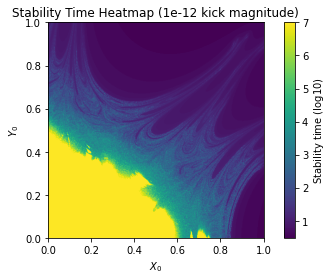

In [13]:
plt.figure()
plt.imshow(np.log10(long_tracking_wkick2["stability_time"]), origin="lower", extent=[0,1,0,1])

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.colorbar(label="Stability time $(\\log10)$")
plt.title("Stability Time Heatmap (1e-12 kick magnitude)")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time_wkicks_1e-12.png"), dpi=DPI)

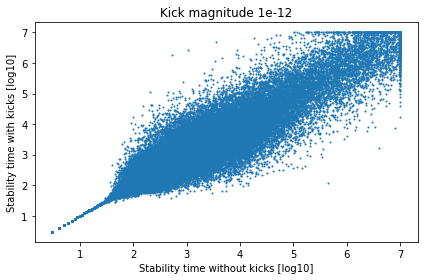

In [14]:
plt.figure()

plt.scatter(
    np.log10(long_tracking["stability_time"]), 
    np.log10(long_tracking_wkick["stability_time"]),
    s=1)

plt.xlabel("Stability time without kicks [log10]")
plt.ylabel("Stability time with kicks [log10]")
plt.title("Kick magnitude 1e-12")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time_vs_wkicks_1e-12.png"), dpi=DPI)

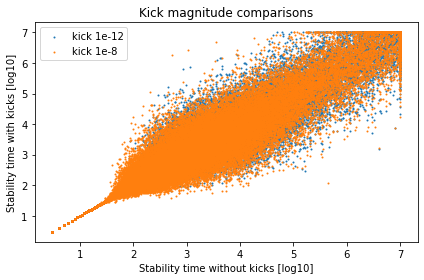

In [15]:
plt.figure()

plt.scatter(
    np.log10(long_tracking["stability_time"]), 
    np.log10(long_tracking_wkick2["stability_time"]),
    s=1,
    label="kick 1e-12")
plt.scatter(
    np.log10(long_tracking["stability_time"]), 
    np.log10(long_tracking_wkick["stability_time"]),
    s=1,
    label="kick 1e-8")

plt.xlabel("Stability time without kicks [log10]")
plt.ylabel("Stability time with kicks [log10]")
plt.title("Kick magnitude comparisons")

plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_stab_time_vs_wkicks_double.png"), dpi=DPI)

## Lyapunov

In [16]:
displacement = h5py.File(os.path.join(inputdir, displacement_file), mode='r')

This ```turn samples``` thingy here is valid for all the datasets...

In [87]:
turn_samples = np.logspace(np.log10(displacement.attrs["min_turns"]), np.log10(displacement.attrs["max_turns"]), displacement.attrs["samples"], dtype=int)

### Basic fast Lyapunov indicator

In [18]:
LI = []
for t in turn_samples:
    sample = displacement[str(t)]
    LI.append(np.log10(np.sqrt(
        np.power(sample["x"][0] - sample["x"][1], 2) +
        np.power(sample["px"][0] - sample["px"][1], 2) +
        np.power(sample["y"][0] - sample["y"][1], 2) +
        np.power(sample["py"][0] - sample["py"][1], 2)
    ) / displacement.attrs["displacement"] ) / t)
LI = np.asarray(LI)

Text(0, 0.5, '$Y_0$')

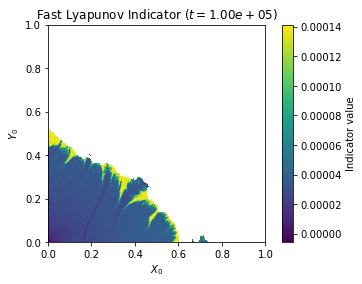

In [19]:
plt.figure()

plt.imshow(LI[-1], origin="lower", extent=[0,1,0,1])
plt.colorbar(label="Indicator value")
plt.title("Fast Lyapunov Indicator $(t={:.2e})$".format(turn_samples[-1]))

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")

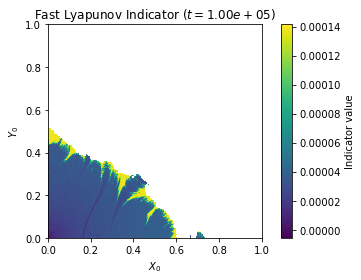

In [21]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LI[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("Fast Lyapunov Indicator $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## Vectorized Faddeev Leverrier algorithm

In [22]:
def faddeev_leverrier(m, grade=1):
    assert grade > 0
    step = 1
    B = m.copy()
    p = np.trace(B)
    while step != grade:
        step += 1
        B = np.matmul(m, B - np.identity(B.shape[-1]) * p)
        p = np.trace(B) * (1 / step)
    return p * ((-1) ** (grade + 1))

v_faddeev_leverrier = np.vectorize(faddeev_leverrier, signature="(n,m),(1)->(1)")

### Invariant Lyapunov (LEI)

In [23]:
orto_displacement = h5py.File(os.path.join(inputdir, orto_displacement_file), mode='r')

In [24]:
sample = orto_displacement[str(turn_samples[-1])]

In [25]:
LEI_1 = []
LEI_2 = []
LEI_3 = []
LEI_4 = []
for t in tqdm(turn_samples[:]): 
    sample = orto_displacement[str(t)]

    t11 = sample["x"][1] - sample["x"][0]
    t12 = sample["px"][1] - sample["px"][0]
    t13 = sample["y"][1] - sample["y"][0]
    t14 = sample["py"][1] - sample["py"][0]

    t21 = sample["x"][2] - sample["x"][0]
    t22 = sample["px"][2] - sample["px"][0]
    t23 = sample["y"][2] - sample["y"][0]
    t24 = sample["py"][2] - sample["py"][0]

    t31 = sample["x"][3] - sample["x"][0]
    t32 = sample["px"][3] - sample["px"][0]
    t33 = sample["y"][3] - sample["y"][0]
    t34 = sample["py"][3] - sample["py"][0]

    t41 = sample["x"][4] - sample["x"][0]
    t42 = sample["px"][4] - sample["px"][0]
    t43 = sample["y"][4] - sample["y"][0]
    t44 = sample["py"][4] - sample["py"][0]

    tm = np.transpose(np.array([
            [t11, t12, t13, t14],
            [t21, t22, t23, t24],
            [t31, t32, t33, t34],
            [t41, t42, t43, t44]
        ]), axes=(2, 3, 0, 1))
    tmt = np.transpose(tm, axes=(0, 1, 3, 2))
    LEI_1.append(v_faddeev_leverrier(np.matmul(tmt, tm), [1])[:,:,0])
    LEI_2.append(v_faddeev_leverrier(np.matmul(tmt, tm), [2])[:,:,0])
    LEI_3.append(v_faddeev_leverrier(np.matmul(tmt, tm), [3])[:,:,0])
    LEI_4.append(v_faddeev_leverrier(np.matmul(tmt, tm), [4])[:,:,0])
    
    #LEI_1.append(np.log10(np.sqrt(np.trace(np.matmul(tmt,tm), axis1=2, axis2=3))/orto_displacement.attrs["displacement"])/t)
LEI_1 = np.asarray(LEI_1)
LEI_2 = np.asarray(LEI_2)
LEI_3 = np.asarray(LEI_3)
LEI_4 = np.asarray(LEI_4)

## POST PROCESSING VERSION FOR MAKING IT COMPARABLE WITH LI
LEI_1_PP = np.log10(np.sqrt(LEI_1)/orto_displacement.attrs["displacement"])/turn_samples[:,None, None]
LEI_2_PP = np.log10(np.sqrt(LEI_2)/orto_displacement.attrs["displacement"])/turn_samples[:,None, None]
LEI_3_PP = np.log10(np.sqrt(LEI_3)/orto_displacement.attrs["displacement"])/turn_samples[:,None, None]
LEI_4_PP = np.log10(np.sqrt(LEI_4)/orto_displacement.attrs["displacement"])/turn_samples[:,None, None]

<ipython-input-25-802277e581d5>:49: RuntimeWarning: invalid value encountered in sqrt
  LEI_3_PP = np.log10(np.sqrt(LEI_3)/orto_displacement.attrs["displacement"])/turn_samples[:,None, None]
<ipython-input-25-802277e581d5>:49: RuntimeWarning: divide by zero encountered in log10
  LEI_3_PP = np.log10(np.sqrt(LEI_3)/orto_displacement.attrs["displacement"])/turn_samples[:,None, None]
<ipython-input-25-802277e581d5>:50: RuntimeWarning: invalid value encountered in sqrt
  LEI_4_PP = np.log10(np.sqrt(LEI_4)/orto_displacement.attrs["displacement"])/turn_samples[:,None, None]


In [26]:
LEI_dump = h5py.File(os.path.join(inputdir, "henon_4d_lei_data_" + eps_mu_label + "id_basic_view_subid_1e-14.hdf5"), mode='w')

LEI_dump.attrs["source"] = orto_displacement_file

LEI_dump.create_dataset("LEI_1", data=LEI_1)
LEI_dump.create_dataset("LEI_2", data=LEI_2)
LEI_dump.create_dataset("LEI_3", data=LEI_3)
LEI_dump.create_dataset("LEI_4", data=LEI_4)

LEI_dump.create_dataset("LEI_1_PP", data=LEI_1_PP)
LEI_dump.create_dataset("LEI_2_PP", data=LEI_2_PP)
LEI_dump.create_dataset("LEI_3_PP", data=LEI_3_PP)
LEI_dump.create_dataset("LEI_4_PP", data=LEI_4_PP)

LEI_dump.close()

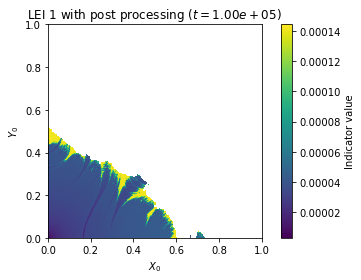

In [27]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_1_PP[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 1 with post processing $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_1_PP_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

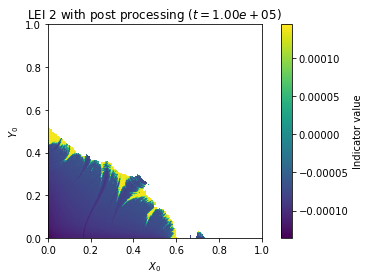

In [28]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_2_PP[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 2 with post processing $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_2_PP_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

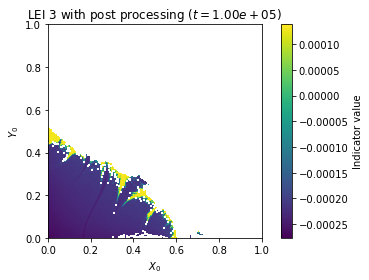

In [29]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_3_PP[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 3 with post processing $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_3_PP_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

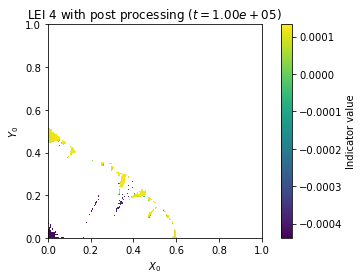

In [30]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_4_PP[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 4 with post processing $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_4_PP_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

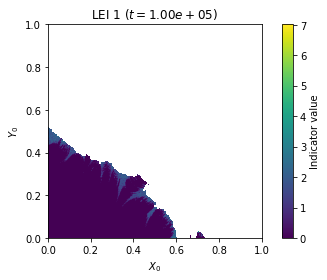

In [31]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_1[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 1 $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_1_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

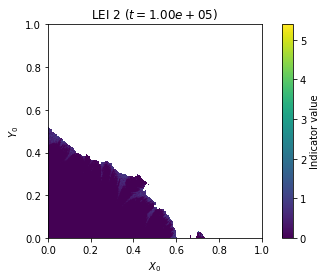

In [32]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_2[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 2 $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_2_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

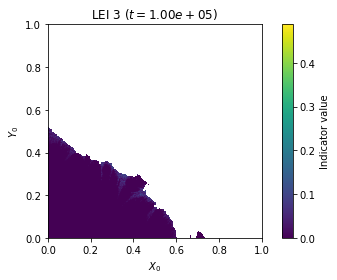

In [33]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_3[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 3 $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_3_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

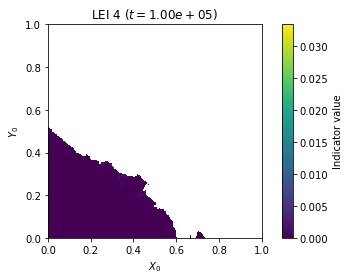

In [34]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(LEI_4[i], origin="lower", extent=[0,1,0,1])
    plt.colorbar(label="Indicator value")
    plt.title("LEI 4 $(t={:.2e})$".format(t))

    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_LEI_4_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

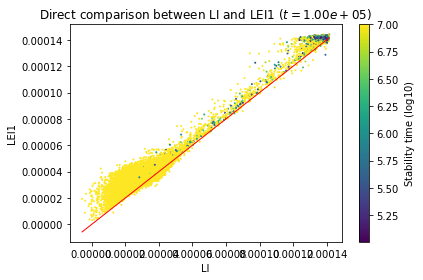

In [48]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LI[i].flatten(),
        LEI_1_PP[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    plt.plot(
        np.linspace(np.nanmin(LI[i]), np.nanmax(LI[i])),
        np.linspace(np.nanmin(LI[i]), np.nanmax(LI[i])),
        c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("LI")
    plt.ylabel("LEI1")
    plt.title("Direct comparison between LI and LEI1 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LI_LEI1_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

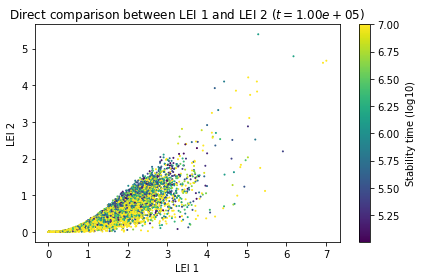

In [49]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LEI_1[i].flatten(),
        LEI_2[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    #plt.plot(
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("LEI 1")
    plt.ylabel("LEI 2")
    plt.title("Direct comparison between LEI 1 and LEI 2 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LEI1_LEI2_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

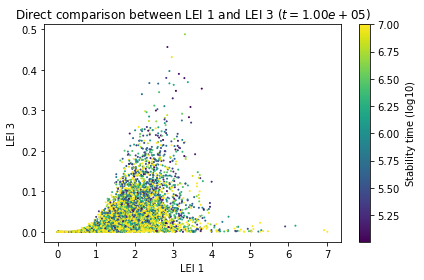

In [50]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LEI_1[i].flatten(),
        LEI_3[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    #plt.plot(
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("LEI 1")
    plt.ylabel("LEI 3")
    plt.title("Direct comparison between LEI 1 and LEI 3 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LEI1_LEI3_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

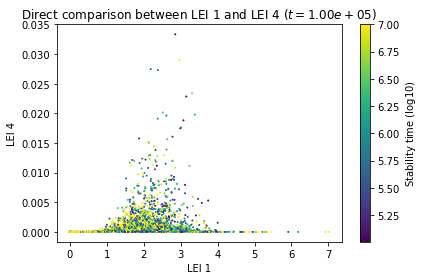

In [51]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LEI_1[i].flatten(),
        LEI_4[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    #plt.plot(
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("LEI 1")
    plt.ylabel("LEI 4")
    plt.title("Direct comparison between LEI 1 and LEI 4 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LEI1_LEI4_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

In [ ]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LEI_1_PP[i].flatten(),
        LEI_2_PP[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    #plt.plot(
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("LEI 1")
    plt.ylabel("LEI 2")
    plt.title("Direct comparison between LEI 1 and LEI 2 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LEI1_LEI2_PP_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

In [ ]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LEI_1_PP[i].flatten(),
        LEI_3_PP[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    #plt.plot(
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("LEI 1")
    plt.ylabel("LEI 3")
    plt.title("Direct comparison between LEI 1 and LEI 3 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LEI1_LEI3_PP_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

In [ ]:
plt.figure()
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        LEI_1_PP[i].flatten(),
        LEI_4_PP[i].flatten(),
        s=1, label="data",
        c=np.log10(long_tracking["stability_time"]).flatten(), cmap="viridis"
    )
    #plt.plot(
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    np.linspace(np.nanmin(LEI_1[i]), np.nanmax(LEI_1[i])),
    #    c="red", label="$x=y$", linewidth=1)
    plt.colorbar(label="Stability time $(\\log10)$")
    plt.xlabel("LEI 1")
    plt.ylabel("LEI 4")
    plt.title("Direct comparison between LEI 1 and LEI 4 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_LEI1_LEI4_PP_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## New FFT data

In [39]:
fft_data = h5py.File(os.path.join(inputdir, fft_file), mode='r')

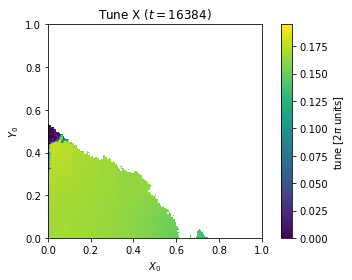

In [41]:
plt.figure()
plt.imshow(fft_data["14/tune_x"][0], origin="lower", extent=[0,1,0,1])
plt.colorbar(label="tune $[2\\pi$ units$]$")

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.title("Tune X $(t={})$".format(2**14))

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_tune_x.png"), dpi=DPI)

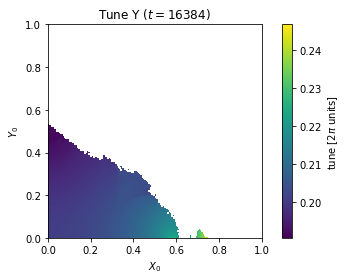

In [42]:
plt.figure()
plt.imshow(fft_data["14/tune_y"][0], origin="lower", extent=[0,1,0,1])
plt.colorbar(label="tune $[2\\pi$ units$]$")

plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")
plt.title("Tune Y $(t={})$".format(2**14))

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_tune_y.png"), dpi=DPI)

<ipython-input-46-adc78bb91eac>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data), origin="lower", extent=[0,1,0,1])


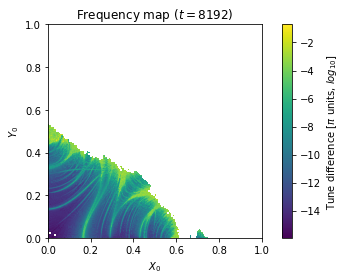

In [46]:
plt.figure()
data = np.sqrt(
    +np.power(fft_data["13/tune_x"][0] - fft_data["13/tune_x"][1], 2)
    +np.power(fft_data["13/tune_y"][0] - fft_data["13/tune_y"][1], 2)
)
plt.imshow(np.log10(data), origin="lower", extent=[0,1,0,1])
plt.colorbar(label="Tune difference $[\\pi$ units, $log_{10}]$")

plt.title("Frequency map $(t={})$".format(2**13))
plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_frequency_map_13_log.png"), dpi=DPI)

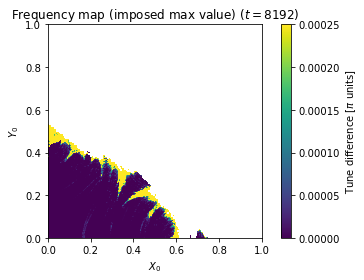

In [45]:
plt.figure()
data = np.sqrt(
    +np.power(fft_data["13/tune_x"][0] - fft_data["13/tune_x"][1], 2)
    +np.power(fft_data["13/tune_y"][0] - fft_data["13/tune_y"][1], 2)
)
plt.imshow((data), origin="lower", extent=[0,1,0,1], vmax=0.00025)
plt.colorbar(label="Tune difference $[\\pi$ units$]$")

plt.title("Frequency map (imposed max value) $(t={})$".format(2**13))
plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_frequency_map_13_wmax.png"), dpi=DPI)

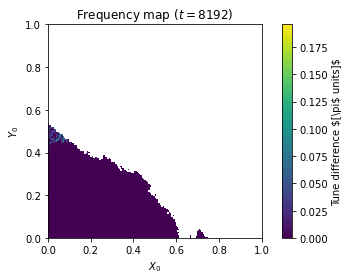

In [47]:
plt.figure()
data = np.sqrt(
    +np.power(fft_data["13/tune_x"][0] - fft_data["13/tune_x"][1], 2)
    +np.power(fft_data["13/tune_y"][0] - fft_data["13/tune_y"][1], 2)
)
plt.imshow((data), origin="lower", extent=[0,1,0,1])
plt.colorbar(label="Tune difference $[\\pi$ units]$")

plt.title("Frequency map $(t={})$".format(2**13))
plt.xlabel("$X_0$")
plt.ylabel("$Y_0$")

plt.tight_layout()
plt.savefig(os.path.join(imgdir, "henon_4d_frequency_map_13.png"), dpi=DPI)

In [ ]:
plt.figure()

known_x_tune = 0.168
known_y_tune = 0.201

min_resonance = 2
max_resonance = 6
colors = ["red", "blue", "green", "orange", "cyan"]
alpha = 1.0

plt.axhline(known_y_tune, color="grey", label="known freq.")
plt.axvline(known_x_tune, color="grey")

x = np.linspace(0,1,100)

for i in list(range(min_resonance, max_resonance + 1))[::-1]:
    for j in range(1, i):
        nx = j
        ny = i - j
        for q in range(0, i+1):
            plt.plot(x, q/ny - nx / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - nx / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/ny - (-nx) / ny * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
            plt.plot(x, q/(-ny) - (-nx) / (-ny) * x,
                     color=colors[i-min_resonance], alpha=alpha, zorder=1)
    for j in range(i+1):
        plt.axvline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1) if j != 0 else plt.axvline(
            j/i, color=colors[i-min_resonance], label="res {}".format(i), alpha=alpha, zorder=1)
        plt.axhline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1)

plt.scatter(fft_data["14/tune_x"][0].flatten(), fft_data["14/tune_y"][0].flatten(), s=0.5,
            marker="x", c=np.log10(long_tracking["stability_time"]), cmap='viridis', label="data", zorder=1)

plt.scatter(known_x_tune, known_y_tune, marker="*", color="grey")

plt.colorbar(label="Stability time (log10)")
        
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("tune $x$ [$2\\pi$ units]")
plt.ylabel("tune $y$ [$2\\pi$ units]")
plt.legend(ncol=2)
plt.title("Resonance Plot")

In [ ]:
plt.figure()
import matplotlib.patches as mpatches

tolerance = 1e-3

min_resonance = 2
max_resonance = 6
cmaps = ["Reds", "Oranges", "Greens", "Blues", "Purples"][::-1]
patches = []

data = np.zero_like((fft_data["14/tune_x"][0].shape[0], fft_data["14/tune_x"][0].shape[1], 3))

for i in list(range(min_resonance, max_resonance + 1))[::-1]:
    csamples = np.linspace(0.2, 1, (i+1) * 4)
    for j in range(0, i+1):
        nx = j
        ny = i - j
        
        bool_mask = nx * fft_data["14/tune_x"][0] + ny * fft_data["14/tune_y"][0] < tolerance
        if np.any(bool_mask):
            patches.append(mpatches.Patch(color='red', label='The red data')
plt.legend(handles=[red_patch]))
        
        
    for j in range(i+1):
        plt.axvline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1) if j != 0 else plt.axvline(
            j/i, color=colors[i-min_resonance], label="res {}".format(i), alpha=alpha, zorder=1)
        plt.axhline(j/i, color=colors[i-min_resonance], alpha=alpha, zorder=1)

plt.scatter(fft_data["14/tune_x"][0].flatten(), fft_data["14/tune_y"][0].flatten(), s=0.5,
            marker="x", c=np.log10(long_tracking["stability_time"]), cmap='viridis', label="data", zorder=1)

plt.scatter(known_x_tune, known_y_tune, marker="*", color="grey")

plt.colorbar(label="Stability time (log10)")
        
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("tune $x$ [$2\\pi$ units]")
plt.ylabel("tune $y$ [$2\\pi$ units]")
plt.legend(ncol=2)
plt.title("Resonance Plot")

## Inversion error

In [ ]:
def make_REI_matrix(x0, px0, y0, py0, x, px, y, py):
    d_x = x - x0
    d_px = px - px0
    d_y = y - y0
    d_py = py - py0
    return np.transpose(np.array([
        [d_x  * d_x, d_x  * d_px, d_x  * d_y, d_x  * d_py],
        [d_px * d_x, d_px * d_px, d_px * d_y, d_px * d_py],
        [d_y  * d_x, d_y  * d_px, d_y  * d_y, d_y  * d_py],
        [d_py * d_x, d_py * d_px, d_py * d_y, d_py * d_py],
    ]), axes=(2,3,0,1))

In [ ]:
inversion_pure = h5py.File(os.path.join(inputdir, inversion_file), mode='r')
inversion_gauss = h5py.File(os.path.join(inputdir, inversion_gauss_file), mode='r')
inversion_uniform = h5py.File(os.path.join(inputdir, inversion_uniform_file), mode='r')
inversion_gauss_forward = h5py.File(os.path.join(inputdir, inversion_gauss_forward_file), mode='r')
inversion_uniform_forward = h5py.File(os.path.join(inputdir, inversion_uniform_forward_file), mode='r')

In [ ]:
RE = []
RE_U = []
RE_G = []
RE_U_F = []
RE_G_F = []

for t in tqdm(turn_samples):
    RE.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_pure[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_pure[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_pure[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_pure[str(t)]["py"][...], 2)
    ))
    RE_U.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_uniform[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_uniform[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_uniform[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_uniform[str(t)]["py"][...], 2)
    ))
    RE_G.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_gauss[str(t)]["x"], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_gauss[str(t)]["px"], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_gauss[str(t)]["y"], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_gauss[str(t)]["py"], 2)
    ))
    RE_U_F.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_uniform_forward[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_uniform_forward[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_uniform_forward[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_uniform_forward[str(t)]["py"][...], 2)
    ))
    RE_G_F.append(np.sqrt(
        + np.power(initial_conditions["coords/x"][...] - inversion_gauss_forward[str(t)]["x"][...], 2)
        + np.power(initial_conditions["coords/px"][...] - inversion_gauss_forward[str(t)]["px"][...], 2)
        + np.power(initial_conditions["coords/y"][...] - inversion_gauss_forward[str(t)]["y"][...], 2)
        + np.power(initial_conditions["coords/py"][...] - inversion_gauss_forward[str(t)]["py"][...], 2)
    ))

RE = np.asarray(RE)
RE_U = np.asarray(RE_U)
RE_G = np.asarray(RE_G)
RE_U_F = np.asarray(RE_U_F)
RE_G_F = np.asarray(RE_G_F)

In [ ]:
REI1 = []
REI1_U = []
REI1_G = []
REI1_U_F = []
REI1_G_F = []
REI2 = []
REI2_U = []
REI2_G = []
REI2_U_F = []
REI2_G_F = []
REI3 = []
REI3_U = []
REI3_G = []
REI3_U_F = []
REI3_G_F = []
REI4 = []
REI4_U = []
REI4_G = []
REI4_U_F = []
REI4_G_F = []

for t in tqdm(turn_samples):
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_pure[str(t)]["x"][...],
        inversion_pure[str(t)]["px"][...],
        inversion_pure[str(t)]["y"][...],
        inversion_pure[str(t)]["py"][...]
    )
    REI1.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_uniform[str(t)]["x"][...],
        inversion_uniform[str(t)]["px"][...],
        inversion_uniform[str(t)]["y"][...],
        inversion_uniform[str(t)]["py"][...]
    )
    REI1_U.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_U.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_U.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_U.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_gauss[str(t)]["x"][...],
        inversion_gauss[str(t)]["px"][...],
        inversion_gauss[str(t)]["y"][...],
        inversion_gauss[str(t)]["py"][...]
    )
    REI1_G.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_G.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_G.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_G.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_uniform_forward[str(t)]["x"][...],
        inversion_uniform_forward[str(t)]["px"][...],
        inversion_uniform_forward[str(t)]["y"][...],
        inversion_uniform_forward[str(t)]["py"][...]
    )
    REI1_U_F.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_U_F.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_U_F.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_U_F.append(v_faddeev_leverrier(matrix, [4])[:,:,1])
    
    matrix = make_REI_matrix(
        initial_conditions["coords/x"][...],
        initial_conditions["coords/px"][...],
        initial_conditions["coords/y"][...],
        initial_conditions["coords/py"][...],
        inversion_gauss_forward[str(t)]["x"][...],
        inversion_gauss_forward[str(t)]["px"][...],
        inversion_gauss_forward[str(t)]["y"][...],
        inversion_gauss_forward[str(t)]["py"][...]
    )
    REI1_G_F.append(v_faddeev_leverrier(matrix, [1])[:,:,1])
    REI2_G_F.append(v_faddeev_leverrier(matrix, [2])[:,:,1])
    REI3_G_F.append(v_faddeev_leverrier(matrix, [3])[:,:,1])
    REI4_G_F.append(v_faddeev_leverrier(matrix, [4])[:,:,1])

REI1 = np.asarray(REI1)
REI1_U = np.asarray(REI1_U)
REI1_G = np.asarray(REI1_G)
REI1_U_F = np.asarray(REI1_U_F)
REI1_G_F = np.asarray(REI1_G_F)

REI2 = np.asarray(REI2)
REI2_U = np.asarray(REI2_U)
REI2_G = np.asarray(REI2_G)
REI2_U_F = np.asarray(REI2_U_F)
REI2_G_F = np.asarray(REI2_G_F)

REI3 = np.asarray(REI3)
REI3_U = np.asarray(REI3_U)
REI3_G = np.asarray(REI3_G)
REI3_U_F = np.asarray(REI3_U_F)
REI3_G_F = np.asarray(REI3_G_F)

REI4 = np.asarray(REI4)
REI4_U = np.asarray(REI4_U)
REI4_G = np.asarray(REI4_G)
REI4_U_F = np.asarray(REI4_U_F)
REI4_G_F = np.asarray(REI4_G_F)

  0%|          | 0/61 [00:00<?, ?it/s]

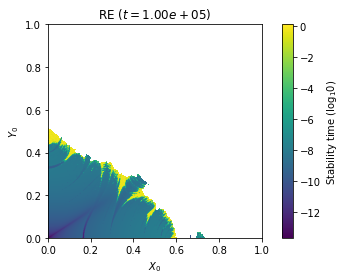

In [36]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(RE[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_RE_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

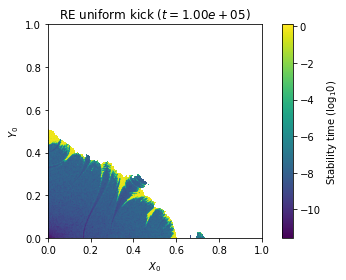

In [37]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(RE_U[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE uniform kick $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_RE_unif_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

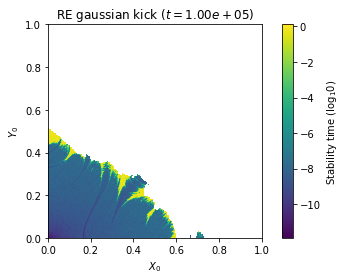

In [38]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(RE_G[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE gaussian kick $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_RE_gauss_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

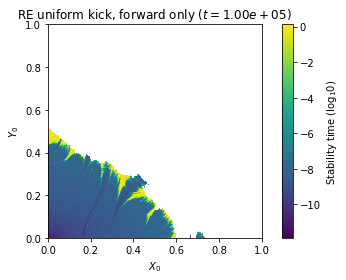

In [39]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(RE_U_F[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE uniform kick, forward only $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_REF_unif_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()
    

  0%|          | 0/61 [00:00<?, ?it/s]

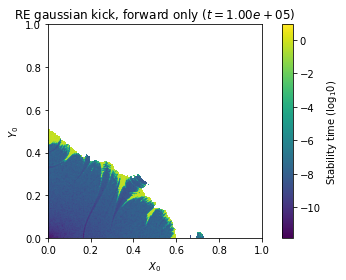

In [40]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(RE_G_F[i]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Stability time $(\\log_10)$")
    plt.title("RE gaussian kick, forward only $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_REF_gauss_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()
    

In [32]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

  0%|          | 0/61 [00:00<?, ?it/s]

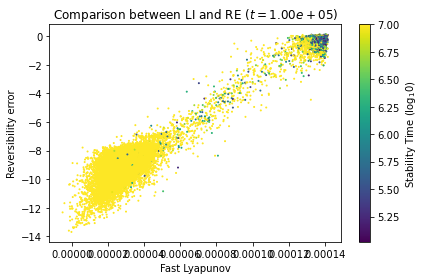

In [42]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    idx = find_nearest(turn_samples, t)[0]
    plt.scatter(LI[idx], np.log10(RE[i]), s=1, c=np.log10(long_tracking["stability_time"]), cmap="viridis")
    plt.colorbar(label="Stability Time $(\\log_10)$")
    plt.xlabel("Fast Lyapunov")
    plt.ylabel("Reversibility error")
    plt.title("Comparison between LI and RE $(t = {:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_RE_LI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

  0%|          | 0/61 [00:00<?, ?it/s]

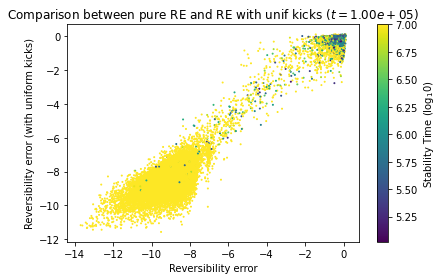

In [43]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(np.log10(RE[i]), np.log10(RE_U[i]), s=1, c=np.log10(long_tracking["stability_time"]), cmap="viridis")
    plt.colorbar(label="Stability Time $(\\log_10)$")
    plt.xlabel("Reversibility error")
    plt.ylabel("Reversibility error (with uniform kicks)")
    plt.title("Comparison between pure RE and RE with unif kicks $(t = {:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_RE_REU_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

  0%|          | 0/61 [00:00<?, ?it/s]

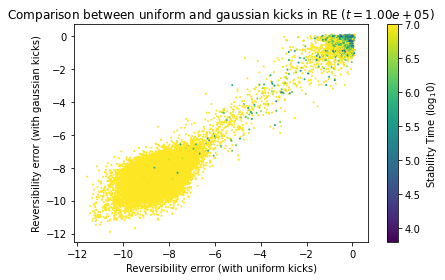

In [44]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(np.log10(RE_U[i]), np.log10(RE_G[i]), s=1, c=np.log10(long_tracking["stability_time"]), cmap="viridis")
    plt.colorbar(label="Stability Time $(\\log_10)$")
    plt.xlabel("Reversibility error (with uniform kicks)")
    plt.ylabel("Reversibility error (with gaussian kicks)")
    plt.title("Comparison between uniform and gaussian kicks in RE $(t = {:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_REU_REG_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## Comparisons with stability time

In [37]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        LI[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("Fast Lyapunov")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_LI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/101 [00:00<?, ?it/s]

In [38]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        LEI_1[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("Invariant Lyapunov")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_LEI_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/101 [00:00<?, ?it/s]

In [39]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        RE[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("RE")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_RE_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.scatter(
        np.log10(long_tracking["stability_time"][...].flatten()),
        RE_U_F[i].flatten(),
        s=1, label="data",
    )
    plt.ylabel("RE")
    plt.xlabel("Stability time [log10]")
    plt.title("Direct comparison between stability time and LI $(t={:.2e})$".format(t))
    
    #plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_vs_time_REUF_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## MEGNO

In [54]:
megno_data = h5py.File(os.path.join(inputdir, megno_file), mode='r')

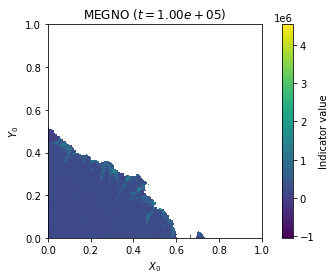

In [56]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow((megno_data[str(t)]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Indicator value")
    plt.title("MEGNO $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_megno_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## SALI

In [60]:
sali_data = h5py.File(os.path.join(inputdir, sali_file), mode='r')

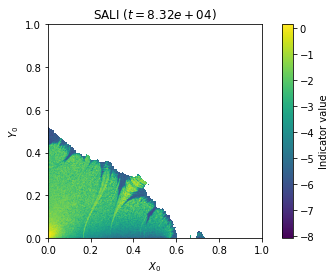

In [61]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(sali_data[str(t)]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Indicator value")
    plt.title("SALI $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_sali_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

## GALI

In [62]:
gali_data = h5py.File(os.path.join(inputdir, gali_file), mode='r')

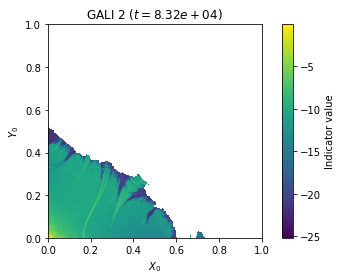

In [63]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(gali_data["gali2"][str(t)]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Indicator value")
    plt.title("GALI 2 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_gali2_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

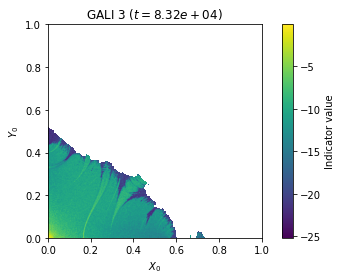

In [64]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(gali_data["gali3"][str(t)]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Indicator value")
    plt.title("GALI 3 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_gali3_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

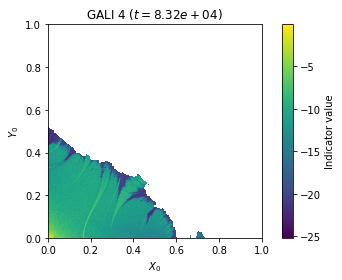

In [65]:
plt.figure()

for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    plt.imshow(np.log10(gali_data["gali4"][str(t)]), origin="lower", extent=[0,1,0,1])
    
    plt.xlabel("$X_0$")
    plt.ylabel("$Y_0$")
    plt.colorbar(label="Indicator value")
    plt.title("GALI 4 $(t={:.2e})$".format(t))
    
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_gali4_{}.png".format(i)), dpi=DPI)
    plt.clf() if i != len(turn_samples) - 1 else plt.show()

# CONFUSION PLOTS

In [72]:
import seaborn as sns

In [79]:
def make_confusion_data(stability_data, dynamic_data, value_sampling, reverse=False):
    bool_mask = np.logical_not(np.isnan(dynamic_data))
    dynamic_data = dynamic_data[bool_mask]
    stability_data = stability_data[bool_mask]
    valid_samples = np.count_nonzero(bool_mask)
    
    tp = np.empty(len(value_sampling))
    tn = np.empty(len(value_sampling))
    fp = np.empty(len(value_sampling))
    fn = np.empty(len(value_sampling))
    
    if not reverse:
        for i, v in enumerate(value_sampling):
            tp[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data>=v))
            fp[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data>=v))
            fn[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data<v))
            tn[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data<v))
    else:
        for i, v in enumerate(value_sampling):
            tp[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data<v))
            fp[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data<v))
            fn[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data>=v))
            tn[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data>=v))
    
    return tp/valid_samples, fp/valid_samples, tn/valid_samples, fn/valid_samples, valid_samples

In [94]:
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    value_sampling = np.linspace(np.nanmin(LI[i]), np.nanmax(LI[i]), 1000)

    tp, fp, tn, fn, vs = make_confusion_data(
        long_tracking["stability_time"][...].flatten(),
        LI[i].flatten(),
        value_sampling,
        reverse=True
    )

    best_idx = np.argmax(tp + tn)
    
    plt.figure()

    plt.plot(value_sampling, tp, label="True Positive")
    plt.plot(value_sampling, fp, label="False Positive")
    plt.plot(value_sampling, tn, label="True Negative")
    plt.plot(value_sampling, fn, label="False Negative")

    plt.plot(value_sampling, tn + tp, "--", label="Correct classification", c="black")
    plt.plot(value_sampling, fn + fp, "--", label="Wrong classification", c="grey")

    plt.xlabel("Threshold value")
    plt.ylabel("Proportion")

    plt.title("Using LI for selecting stable particles (t={:.2e})".format(t))

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_selecting_LI_{}.png".format(i)), dpi=DPI)
    
    plt.close()
    
    fig, ax = plt.subplots()

    cf_matrix = np.array(
        [[tn[best_idx], fp[best_idx]],
        [fn[best_idx], tp[best_idx]]]
    )
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()*vs]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title("LI confusion matrix (threshold = {}, t = {:.2e})".format(value_sampling[i], t))
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    
    plt.savefig(os.path.join(imgdir, "henon_4d_confusion_LI_{}.png".format(i)), dpi=DPI)
    plt.close()

<ipython-input-94-5e4c7adb3397>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-94-5e4c7adb3397>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-94-5e4c7adb3397>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-94-5e4c7adb33

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [96]:
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    value_sampling = np.linspace(np.nanmin(LEI_1_PP[i]), np.nanmax(LEI_1_PP[i]), 1000)

    tp, fp, tn, fn, vs = make_confusion_data(
        long_tracking["stability_time"][...].flatten(),
        LEI_1_PP[i].flatten(),
        value_sampling,
        reverse=True
    )

    best_idx = np.argmax(tp + tn)
    
    plt.figure()

    plt.plot(value_sampling, tp, label="True Positive")
    plt.plot(value_sampling, fp, label="False Positive")
    plt.plot(value_sampling, tn, label="True Negative")
    plt.plot(value_sampling, fn, label="False Negative")

    plt.plot(value_sampling, tn + tp, "--", label="Correct classification", c="black")
    plt.plot(value_sampling, fn + fp, "--", label="Wrong classification", c="grey")

    plt.xlabel("Threshold value")
    plt.ylabel("Proportion")

    plt.title("Using LEI 1 for selecting stable particles (t={:.2e})".format(t))

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_selecting_LEI1_{}.png".format(i)), dpi=DPI)
    
    plt.close()
    
    fig, ax = plt.subplots()

    cf_matrix = np.array(
        [[tn[best_idx], fp[best_idx]],
        [fn[best_idx], tp[best_idx]]]
    )
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()*vs]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title("LEI 1 confusion matrix (threshold = {}, t = {:.2e})".format(value_sampling[i], t))
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    
    plt.savefig(os.path.join(imgdir, "henon_4d_confusion_LEI1_{}.png".format(i)), dpi=DPI)
    plt.close()

In [97]:
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    value_sampling = np.linspace(np.nanmin(LEI_2_PP[i]), np.nanmax(LEI_2_PP[i]), 1000)

    tp, fp, tn, fn, vs = make_confusion_data(
        long_tracking["stability_time"][...].flatten(),
        LEI_2_PP[i].flatten(),
        value_sampling,
        reverse=True
    )

    best_idx = np.argmax(tp + tn)
    
    plt.figure()

    plt.plot(value_sampling, tp, label="True Positive")
    plt.plot(value_sampling, fp, label="False Positive")
    plt.plot(value_sampling, tn, label="True Negative")
    plt.plot(value_sampling, fn, label="False Negative")

    plt.plot(value_sampling, tn + tp, "--", label="Correct classification", c="black")
    plt.plot(value_sampling, fn + fp, "--", label="Wrong classification", c="grey")

    plt.xlabel("Threshold value")
    plt.ylabel("Proportion")

    plt.title("Using LEI 2 for selecting stable particles (t={:.2e})".format(t))

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_selecting_LEI2_{}.png".format(i)), dpi=DPI)
    
    plt.close()
    
    fig, ax = plt.subplots()

    cf_matrix = np.array(
        [[tn[best_idx], fp[best_idx]],
        [fn[best_idx], tp[best_idx]]]
    )
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()*vs]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title("LEI 2 confusion matrix (threshold = {}, t = {:.2e})".format(value_sampling[i], t))
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    
    plt.savefig(os.path.join(imgdir, "henon_4d_confusion_LEI2_{}.png".format(i)), dpi=DPI)
    plt.close()

In [98]:
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    value_sampling = np.linspace(np.nanmin(LEI_3_PP[i]), np.nanmax(LEI_3_PP[i]), 1000)

    tp, fp, tn, fn, vs = make_confusion_data(
        long_tracking["stability_time"][...].flatten(),
        LEI_3_PP[i].flatten(),
        value_sampling,
        reverse=True
    )

    best_idx = np.argmax(tp + tn)
    
    plt.figure()

    plt.plot(value_sampling, tp, label="True Positive")
    plt.plot(value_sampling, fp, label="False Positive")
    plt.plot(value_sampling, tn, label="True Negative")
    plt.plot(value_sampling, fn, label="False Negative")

    plt.plot(value_sampling, tn + tp, "--", label="Correct classification", c="black")
    plt.plot(value_sampling, fn + fp, "--", label="Wrong classification", c="grey")

    plt.xlabel("Threshold value")
    plt.ylabel("Proportion")

    plt.title("Using LEI 3 for selecting stable particles (t={:.2e})".format(t))

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_selecting_LEI3_{}.png".format(i)), dpi=DPI)
    
    plt.close()
    
    fig, ax = plt.subplots()

    cf_matrix = np.array(
        [[tn[best_idx], fp[best_idx]],
        [fn[best_idx], tp[best_idx]]]
    )
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()*vs]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title("LEI 3 confusion matrix (threshold = {}, t = {:.2e})".format(value_sampling[i], t))
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    
    plt.savefig(os.path.join(imgdir, "henon_4d_confusion_LEI3_{}.png".format(i)), dpi=DPI)
    plt.close()

/home/camontan/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/camontan/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:163: RuntimeWarning: invalid value encountered in add
  y += start
<ipython-input-79-9b0a1baeefc3>:20: RuntimeWarning: invalid value encountered in less
  tp[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data<v))
<ipython-input-79-9b0a1baeefc3>:21: RuntimeWarning: invalid value encountered in less
  fp[i] = np.count_nonzero(np.logical_and(stability_data!=stability_data.max(), dynamic_data<v))
<ipython-input-79-9b0a1baeefc3>:22: RuntimeWarning: invalid value encountered in greater_equal
  fn[i] = np.count_nonzero(np.logical_and(stability_data==stability_data.max(), dynamic_data>=v))
<ipython-input-79-9b0a1baeefc3>:23: RuntimeWarning: invalid value encountered in greater_equal
  tn[i] = np.count_nonzero(np.logical_and(stab

In [100]:
for i, t in tqdm(enumerate(turn_samples), total=len(turn_samples)):
    value_sampling = np.linspace(np.nanmin(LEI_4_PP[i]), np.nanmax(LEI_4_PP[i]), 1000)

    tp, fp, tn, fn, vs = make_confusion_data(
        long_tracking["stability_time"][...].flatten(),
        LEI_4_PP[i].flatten(),
        value_sampling,
        reverse=True
    )

    best_idx = np.argmax(tp + tn)
    
    plt.figure()

    plt.plot(value_sampling, tp, label="True Positive")
    plt.plot(value_sampling, fp, label="False Positive")
    plt.plot(value_sampling, tn, label="True Negative")
    plt.plot(value_sampling, fn, label="False Negative")

    plt.plot(value_sampling, tn + tp, "--", label="Correct classification", c="black")
    plt.plot(value_sampling, fn + fp, "--", label="Wrong classification", c="grey")

    plt.xlabel("Threshold value")
    plt.ylabel("Proportion")

    plt.title("Using LEI 4 for selecting stable particles (t={:.2e})".format(t))

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, "henon_4d_selecting_LEI4_{}.png".format(i)), dpi=DPI)
    
    plt.close()
    
    fig, ax = plt.subplots()

    cf_matrix = np.array(
        [[tn[best_idx], fp[best_idx]],
        [fn[best_idx], tp[best_idx]]]
    )
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()*vs]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    ax.set_title("LEI 4 confusion matrix (threshold = {}, t = {:.2e})".format(value_sampling[i], t))
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    
    plt.savefig(os.path.join(imgdir, "henon_4d_confusion_LEI4_{}.png".format(i)), dpi=DPI)
    plt.close()